In [1]:
import os
import nibabel as nib
#import SimpleITK as sitk
from torch.utils.data import Dataset
from collections import defaultdict
from natsort import natsorted



In [2]:
import numpy as np
import torch
import SimpleITK as sitk

class MRISegmentationDataset(Dataset):
    def __init__(self, imgs_dir, 
                 img_filetypes=["FLAIR.nii.gz", "T1.nii.gz"],
                 label_filetype="wmh.nii.gz",
                 transform=None,
                 target_transform=None):
        
        # locate each individual, each file should be formatted
        # individual_filetype.fileending
        # if domains == None:
        # domains logic has been commented out because actually
        # we probably want to control how much of each domain we use,
        # not just do it randomly to ensure we get a balanced split.
        # so its better if the domains are combined later and separately.
        imgs_dir_files = os.listdir(os.path.join(imgs_dir, "imgs"))
        target_dir_files = os.listdir(os.path.join(imgs_dir, "labels"))
        # else:
        #     imgs_dir_files = []
        #     target_dir_files = []
        #     for d in domains:
        #         imgs_dir_files.append(os.listdir(os.path.join(imgs_dir, "imgs")))
        #         target_dir_files.append(os.listdir(os.path.join(imgs_dir, "labels")))
        
        # identify each individual
        individuals_map = defaultdict(lambda : {})
        for f in imgs_dir_files:
            try:
                ind = f.split("_")[0]
                filetype = f.split(f"{ind}_")[1]
                if filetype not in img_filetypes:
                    continue # i.e ignore files in the folder that don't match target names exactly (e.g BET files, normalize files etc
            except:
                print(f"file {f} could not be parsed, skipping...")
            
            individuals_map[ind][filetype] = f
            
        # check that each individual has the same number of keys
        expected_keys = len(img_filetypes)
        for ind in individuals_map.keys():
            if len(individuals_map[ind].keys()) != expected_keys:
                raise ValueError(f"for individual {ind} expected exactly the following filetypes: "
                                 f"'{ind}_' + '{expected_keys}' BUT only {list(individuals_map[ind].values())} were found")
                
        # check that each individual has a label
        individuals_labels_map = {}
        for ind in individuals_map.keys():
            label_file = f"{ind}_{label_filetype}"
            if label_file not in target_dir_files:
                raise FileNotFoundError(f"Could not find label {label_file} ")
            else:
                individuals_labels_map[ind] = label_file
        
        # initialize object
        self.imgs_dir = imgs_dir
        self.individuals = natsorted(list(individuals_map.keys()))
        self.img_filetypes = natsorted(list(img_filetypes)) # ensure it is a fixed ordered object
        self.label_filetype = label_filetype
        self.transform = transform
        self.target_transform = target_transform
            
    def __getitem__(self, idx):
        # compute paths to images and labels
        img_paths = [
            os.path.join(*[self.imgs_dir, "imgs", f"{self.individuals[idx]}_{filetype}"])
            for filetype in self.img_filetypes
        ]
        label_path = os.path.join(*[self.imgs_dir, "labels", f"{self.individuals[idx]}_{self.label_filetype}"])

        # loading brain scans
        # images = [nib.load(img_path) for img_path in img_paths]
        # images = [img.get_fdata().astype(np.float32) for img in images]
        # image = np.concatenate(images)
        # label = nib.load(label_path).get_fdata().astype(np.float32)
        
        # sitk equivalent
        images = [sitk.ReadImage(img_path) for img_path in img_paths]
        images = [sitk.GetArrayFromImage(img) for img in images]
        images = [img.astype(np.float32) for img in images]
        label = sitk.ReadImage(label_path)
        label = sitk.GetArrayFromImage(label)
        label = label.astype(np.float32)
        
        # convert to tensors
        if len(images) == 1:
            image = torch.FloatTensor(images[0])
        else:
            images = np.stack(images, axis=0)
            image = torch.FloatTensor(images)
        label = torch.FloatTensor(label).unsqueeze(0) # nesseary to match the dimensions of the images


        """
        THIS MAY BE USEFUL WHEN DEBUGGING THIS, I WILL NEED TO SORT THE DIMENSIONS OUT
        SO THAT THEY MATCH THE WAY I EXPECT, BUT IT IS ROUGHLY THERE

        img_array = torch.FloatTensor(img_array).unsqueeze(0)
    mask_array = torch.FloatTensor(mask_array).unsqueeze(0)

    if self.transforms:
        img_array,mask_array = self.transforms(img_array, mask_array)     
        """

        # apply transforms
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

    def __len__(self):
        return len(self.individuals)
        

In [3]:
domain = "Utrecht"
dataset_utrecht = MRISegmentationDataset(
    imgs_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/WMH_challenge_dataset/" + domain,
    img_filetypes = ["FLAIR.nii.gz", "T1.nii.gz"],
    label_filetype="wmh.nii.gz",
    transform=None,
    target_transform=None
)

In [4]:
img, label = dataset_utrecht[0]

In [5]:
img.shape

torch.Size([2, 48, 230, 230])

In [128]:
img

tensor([[[[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          ...,
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],

         [[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          ...,
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002]],

         [[0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0.0002, 0.0002, 0.0002],
          [0.0002, 0.0002, 0.0002,  ..., 0

formatting issues, pytorch expects input shape N C H W (n=batch, c=channels, height, width). lets sub in sitk and see if it works better.

In [129]:
label.shape

torch.Size([1, 230, 230, 48])

In [130]:
import matplotlib.pyplot as plt

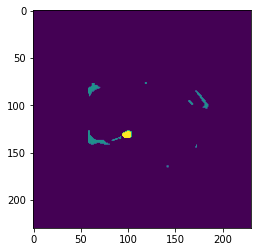

In [131]:
plt.imshow(label[0,:,:,22])

In [132]:
np.unique(label)

array([0., 1., 2.], dtype=float32)

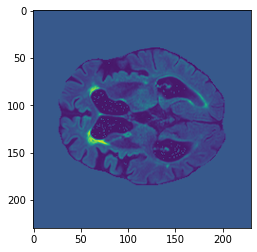

In [133]:
plt.imshow(img[0,:,:,22])

### The label above has two classification values...
does the original and if so what are these


In [63]:
from twaidata.MRI_preprep.io import load_nii_img

In [61]:
orig = "/media/benp/NVMEspare/datasets/MRI_IP_project/WMH_challenge_dataset/public/Utrecht/0"

In [64]:
orig_label_file = orig + "/wmh.nii.gz"

In [66]:
orig_label, _ = load_nii_img(orig_label_file)

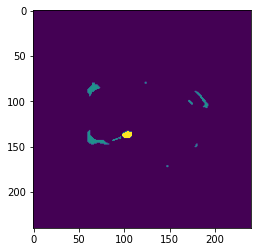

In [67]:
plt.imshow(orig_label[:,:,22])

# the answer
its 0 for backgroud, 1 for white matter, and 2 for other pathology. I'm not sure if using it will help or not.
for now I am going to ignore it.

In [69]:
img.shape

torch.Size([230, 230, 48, 2])